In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
import numba as nb

# Importing figure properties
from figure_test_files.figure_properties import *

# Importing functions
from hamiltonian.hamiltonian import get_hamiltonian
from Bell_operator.Bell_operator import calc_Bell_operator
from classical_optimization.classical_bound import calc_classical_bound

# Defining saving directory
save_dir = '../data/figures/hydrogen_mol/'
save_fdir = '../data/data_sets/hydrogen_mol/'

/home/bowy/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Setting h5py.default_file_mode is deprecated. 'r' (read-only) is the default from h5py 3.0.
  h5py.get_config().default_file_mode = 'r'


In [2]:
# Set parameters to make a simple molecule.
diatomic_bond_length = .7414   # Angstroms
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
# basis = '3-21G'
basis = 'sto-3G'
multiplicity = 1
charge = 0

# Defining qubit transform
qubit_transform = 'JW'

# Obtainig Hamiltonian
hamiltonian = get_hamiltonian(geometry, basis, multiplicity, charge, qubit_transform = qubit_transform)

# Extracting parameters
H = hamiltonian.matrix_form
N = hamiltonian.N

# Calculating the eigenvalues and eigenstates
eig_vals, eig_vecs = np.linalg.eigh(H)

# Extracting the ground state energy and the respective eigenstate
psi_G = np.zeros((2**N, 1))
psi_G[:,0] = eig_vecs[:,0]
rho = np.matmul(psi_G, np.transpose(psi_G))


In [6]:
# Defining small error
eps = 1e-3

# Defining number of measurements and the angle between the two parties
m = nb.typed.List(
    [2,2,2,2]
)
theta = np.random.rand(N-1)*(np.pi-2*eps)+eps

# # Initializing basis and extra Z gate
basis = 'XY'
extra_gate = True

# Calculating the classical bound
beta_C = calc_classical_bound(theta, H, N, m, basis, extra_gate)
print('Classical bound: %.16f' %(beta_C))

# Calculating eigenvalue of the Bell operator
beta_Q = calc_Bell_operator(theta, H, rho, N, m, basis, extra_gate)
print('Quantum bound: %.16f' %(beta_Q))


Classical bound: -1.9579714091862064
Quantum bound: -1.8510241683485202


In [5]:
# Defining a fitting function and a callback function
def fitting_func(theta, H, N, m, basis, extra_Z_gate):

    return -calc_classical_bound(theta, H, N, m, basis, extra_Z_gate)

def callback_function(theta):

    stored_angles.append( theta )
    
    beta_C.append( calc_classical_bound(theta, H, N, m, basis, extra_Z_gate) )

In [32]:
# Set parameters to make a simple molecule.
diatomic_bond_length = .7414   # Angstroms
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3G'
multiplicity = 1
charge = 0

# Defining qubit transform
qubit_transform = 'BK'

# Obtainig Hamiltonian
hamiltonian = get_hamiltonian(geometry, basis, multiplicity, charge, qubit_transform = qubit_transform)

# Extracting parameters
H = hamiltonian.matrix_form
N = hamiltonian.N

# Calculating the eigenvalues and eigenstates
eig_vals, eig_vecs = np.linalg.eigh(H)

# Extracting the ground state energy and the respective eigenstate
psi_G = np.zeros((2**N, 1))
psi_G[:,0] = eig_vecs[:,0]
rho = np.matmul(psi_G, np.transpose(psi_G))



# Calculting the quantum# Defining the number of measurements
m = nb.typed.List(
        [4,3,2,2]
)

# Initializing empty list beta_C for call_back function
beta_C = []
stored_angles = []

# Defining angles
eps = 1e-2
init_guess = np.random.rand(N-1)*(np.pi-2*eps)+eps

# Defining arguments
basis = 'XY'
extra_Z_gate = True
args = (H, N, m, basis, extra_Z_gate)

# Defining minimization options
options = {
        'maxiter'  : 2000,
}


# Compiling the fitting functions
beta_C.append( -fitting_func(init_guess, *args) )

# Defining the minimizer keyword arguments
minimizer_kwargs = {
                'method'  : "Nelder-Mead",
                'args'    : args,
                'options' : options,
                'callback': callback_function
}

res = basinhopping(fitting_func, init_guess,
                minimizer_kwargs = minimizer_kwargs,
                niter = 4,
                disp = True 
)

np.save(save_fdir+'beta_C_BK_m_%.0f.npy' %(np.sum(m)), beta_C)
np.save(save_fdir+'theta_BK_m_%.0f.npy' %(np.sum(m)), stored_angles)

KeyboardInterrupt: 

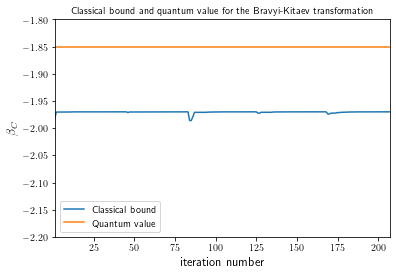

In [33]:
qubit_transform = 'BK'
beta_C = np.load(save_fdir+'beta_C_' +qubit_transform+'_m_11.npy')
angles = np.load(save_fdir+'theta_' +qubit_transform +'_m_11.npy')
fig, ax = plt.subplots()
ax.plot(np.linspace(1, len(beta_C), len(beta_C)), beta_C, label=r'Classical bound')
ax.plot(np.linspace(1, len(beta_C), len(beta_C)), np.real(beta_Q)*np.ones(len(beta_C)), label=r'Quantum value')
ax.set_xlabel(r'iteration number')
ax.set_ylabel(r'$\beta_C$')
ax.set_ylim((-2.2, -1.8))
ax.set_xlim((1, len(beta_C)))
ax.legend()
if qubit_transform == 'JW':
    ax.set_title(r'Classical bound and quantum value for the Jordan Wigner transformation')
    fig.savefig(save_dir + 'classical_bound_Hydrogen_Jordan_Wigner_m_%0f.png' %(np.sum(m)), dpi = 300, bbox_inches='tight');
elif qubit_transform == 'BK':
    ax.set_title(r'Classical bound and quantum value for the Bravyi-Kitaev transformation')
    fig.savefig(save_dir + 'classical_bound_Hydrogen_Bravyi_Kitaev_m_%0f.png' %(np.sum(m)), dpi = 300, bbox_inches='tight');

In [136]:
# Set parameters to make a simple molecule.
diatomic_bond_length = .7414   # Angstroms
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
# basis = '3-21G'
basis = 'sto-3G'
multiplicity = 1
charge = 0

# Defining qubit transform
qubit_transform = 'BK'

# Obtainig Hamiltonian
hamiltonian = get_hamiltonian(geometry, basis, multiplicity, charge, qubit_transform = qubit_transform)

# Extracting parameters
H = hamiltonian.matrix_form
N = hamiltonian.N

# Calculating the eigenvalues and eigenstates
eig_vals, eig_vecs = np.linalg.eigh(H)

# Extracting the ground state energy and the respective eigenstate
psi_G = np.zeros((2**N, 1))
psi_G[:,0] = eig_vecs[:,0]
rho = np.matmul(psi_G, np.transpose(psi_G))


# Calculting the quantum# Defining the number of measurements
m = nb.typed.List(
        [3,3,2,2]
)

# Initializing empty list beta_C for call_back function
beta_C = []
stored_angles = []

# Defining angles
eps = 1e-2
init_guess = np.random.rand(N-1)*(np.pi-2*eps)+eps

# Defining arguments
basis = 'XY'
extra_Z_gate = True
args = (H, N, m, basis, extra_Z_gate)

# Defining minimization options
options = {
        'maxiter'  : 2000,
}

# Defining the minimizer keyword arguments
minimizer_kwargs = {
                'method'  : "Nelder-Mead",
                'args'    : args,
                'options' : options,
                'callback': callback_function
}



res = basinhopping(fitting_func, init_guess,
                minimizer_kwargs = minimizer_kwargs,
                niter = 4,
                disp = True 
)

# np.save(save_fdir+'beta_C_JW_m_%.0f.npy' %(np.sum(m)), beta_C)
# np.save(save_fdir+'theta_JW_m_%.0f.npy' %(np.sum(m)), stored_angles)

basinhopping step 0: f 1.99554
basinhopping step 1: f 1.99554 trial_f 1.99554 accepted 1  lowest_f 1.99554
basinhopping step 2: f 1.99554 trial_f 1.99554 accepted 1  lowest_f 1.99554


KeyboardInterrupt: 

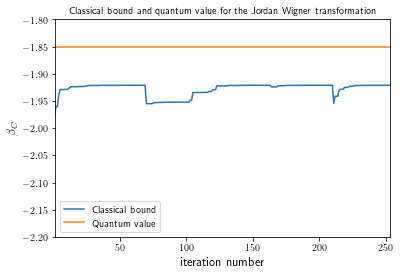

In [ ]:
beta_C = np.load(save_fdir+'beta_C_JW.npy')
angles = np.load(save_fdir+'theta_JW.npy')
qubit_transform = 'JW'
fig, ax = plt.subplots()
ax.plot(np.linspace(1, len(beta_C), len(beta_C)), beta_C, label=r'Classical bound')
ax.plot(np.linspace(1, len(beta_C), len(beta_C)), np.real(beta_Q)*np.ones(len(beta_C)), label=r'Quantum value')
ax.set_xlabel(r'iteration number')
ax.set_ylabel(r'$\beta_C$')
ax.set_ylim((-2.2, -1.8))
ax.set_xlim((1, len(beta_C)))
ax.legend()
if qubit_transform == 'JW':
    ax.set_title(r'Classical bound and quantum value for the Jordan Wigner transformation')
    fig.savefig(save_dir + 'classical_bound_Hydrogen_Jordan_Wigner_m_%0f.png' %(np.sum(m)), dpi = 300, bbox_inches='tight');
elif qubit_transform == 'BK':
    ax.set_title(r'Classical bound and quantum value for the Bravyi-Kitaev transformation')
    fig.savefig(save_dir + 'classical_bound_Hydrogen_Bravyi_Kitaev_m_%0f.png' %(np.sum(m)), dpi = 300, bbox_inches='tight');

/home/bowy/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/bowy/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


-1.9210830746078726
-1.9586291364861452


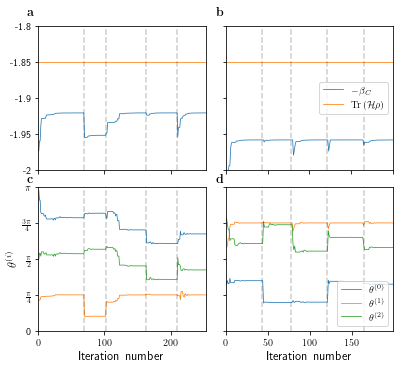

In [94]:
# Importing matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import *

# Initlazing the text locations and linewidth
x_2 = -12
x_1 = -17
lw = .75
y_1 = -1.785
beta_C_JW = np.load(save_fdir+'beta_C_JW.npy')
angles_JW = np.load(save_fdir+'theta_JW.npy')
n_JW = np.linspace(1, len(beta_C_JW), len(beta_C_JW))
scale = 1.3

# initializing figures
fig =plt.figure(figsize=(1/0.75 * lwidth/scale, 1/0.85 * lwidth/scale))
gs = gridspec.GridSpec(
    nrows=2,
    ncols=2,
    figure=fig,
    width_ratios=[1, 1],
    height_ratios=[1,1],
    wspace = 0.12,
    hspace = 0.12
)
ax = fig.add_subplot(gs[0, 0])
ax.plot( n_JW, np.array(beta_C_JW) , label=r'$\beta_C$', linewidth=lw)
ax.plot( n_JW, np.ones(len(beta_C_JW))*np.trace(np.matmul(B, rho)),
    label=r'$\mathrm{Tr}\left( \mathcal{H} \rho \right)$', linewidth=lw
)
# for j in starts:
    # ax.axvline(j, color='k', linestyle='--', alpha=.2)
# ax.set_xlabel(r'Iteration number')
ax.set_xticklabels([])
ax.set_ylim((-2, -1.8))
ax.set_xlim((0, n_JW[-1]))
lines = [70, 103, 163, 210]
for j in lines:
    ax.axvline(j, color='k', linestyle='--', alpha=.2)
# ax.text(x, 5.5, '$\mathbf{a}$',  size = MEDIUM_SIZE)
ax.set_yticks([-2, -1.95, -1.9, -1.85, -1.8])
ax.set_yticklabels([-2, -1.95, -1.9, -1.85, -1.8])
ax.text(x_1, y_1, '$\mathbf{a}$',  size = MEDIUM_SIZE)
print(np.max(beta_C_JW))

ax = fig.add_subplot(gs[1, 0])
angles = np.array(angles_JW)
for j in range(3):
    ax.plot(n_JW, angles[:,j], label=r'$\theta^{(' +str(j)+')}$', linewidth=lw)
lines = [70, 103, 163, 210]
for j in lines:
    ax.axvline(j, color='k', linestyle='--', alpha=.2)
ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_yticklabels([0, r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
ax.set_xlabel(r'Iteration number')
ax.set_ylim((0, np.pi))
ax.set_xlim((0, n_JW[-1]))
ax.set_ylabel(r'$\theta^{(i)}$')
ax.text(x_1, np.pi+.1, '$\mathbf{c}$',  size = MEDIUM_SIZE)



beta_C_JW = np.load(save_fdir+'beta_C_BK.npy')
angles_JW = np.load(save_fdir+'theta_BK.npy')
n_JW = np.linspace(1, len(beta_C_JW), len(beta_C_JW))

ax = fig.add_subplot(gs[0, 1])
ax.plot( n_JW, np.array(beta_C_JW) , label=r'$-\beta_C$', linewidth=lw)
ax.plot( n_JW, np.ones(len(beta_C_JW))*np.trace(np.matmul(B, rho)),
    label=r'$\mathrm{Tr}\left( \mathcal{H} \rho \right)$', linewidth=lw
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylim((-2, -1.8))
ax.set_xlim((0, n_JW[-1]))
ax.legend()
lines = [43, 78, 121, 165]
for j in lines:
    ax.axvline(j, color='k', linestyle='--', alpha=.2)
ax.set_yticks([-2, -1.95, -1.9, -1.85, -1.8])
ax.set_yticklabels([])
ax.text(x_2, y_1, '$\mathbf{b}$',  size = MEDIUM_SIZE)

n_JW = np.linspace(1, len(beta_C_JW)-1, len(beta_C_JW)-1)

ax = fig.add_subplot(gs[1, 1])
angles = np.array(angles_JW)
for j in range(3):
    ax.plot(n_JW, angles[:,j], label=r'$\theta^{(' +str(j)+')}$', linewidth=lw)
lines = [43, 78, 121, 165]
for j in lines:
    ax.axvline(j, color='k', linestyle='--', alpha=.2)
ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_yticklabels([0, r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
ax.set_xlabel(r'Iteration number')
ax.set_ylim((0, np.pi))
ax.set_xlim((0, n_JW[-1]))
ax.legend(loc='lower right')
ax.set_yticklabels([])
ax.text(x_2, np.pi+.1, '$\mathbf{d}$',  size = MEDIUM_SIZE)
print(np.max(beta_C_JW))

# Saving the figure
fig.savefig(save_dir+'results_hydrogen.png', dpi = 300, bbox_inches='tight')   

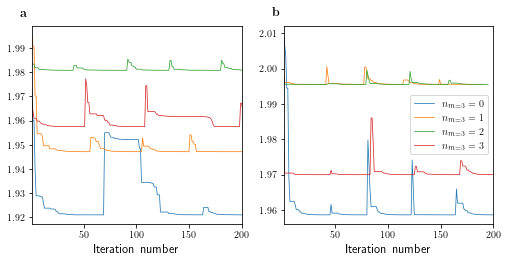

In [135]:
# Importing matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import *

# Initlazing the text locations and linewidth
x = -10
lw = .75

# initializing figures
fig =plt.figure(figsize=(1/0.75 * lwidth, 1/0.85 * lwidth/2))
gs = gridspec.GridSpec(
    nrows=1,
    ncols=2,
    figure=fig,
    width_ratios=[1, 1],
    height_ratios=[1],
    wspace=0.2,
)

beta_C = np.load(save_fdir+'beta_C_JW.npy')
beta_C1 = np.load(save_fdir+'beta_C_JW_m_9.npy')
beta_C2 = np.load(save_fdir+'beta_C_JW_m_10.npy')
beta_C3 = np.load(save_fdir+'beta_C_JW_m_11.npy')
beta_C4 = np.load(save_fdir+'beta_C_JW_m_12.npy')

n = np.linspace(1, len(beta_C), len(beta_C))

ax = fig.add_subplot(gs[0, 0])
ax.plot(np.linspace(1, len(beta_C), len(beta_C)) , -beta_C , label=r'$n_{m=3} = 0$', linewidth=lw)
ax.plot(np.linspace(1, len(beta_C1), len(beta_C1)) , -beta_C1 , label=r'$n_{m=3} = 1$', linewidth=lw)
ax.plot(np.linspace(1, len(beta_C2), len(beta_C2)) , -beta_C2 , label=r'$n_{m=3} = 2$', linewidth=lw)
ax.plot(np.linspace(1, len(beta_C3), len(beta_C3)) , -beta_C3 , label=r'$n_{m=3} = 3$', linewidth=lw)
# ax.plot(np.linspace(1, len(beta_C4), len(beta_C4)) , -beta_C4 , label=r'$n_{m=3} = 4$', linewidth=lw)

# label=r'$\mathrm{Tr}\left( \mathcal{H} \rho \right)$', linewidth=lw)
# ax.legend()
ax.set_xlabel(r'Iteration number')
# ax.set_ylim((-5, 5))
ax.set_xlim((1, 200))
# ax.set_xticks([])
# ax.set_xticklabels([])
ax.text(x, 2.003, '$\mathbf{a}$',  size = MEDIUM_SIZE)

beta_C = np.load(save_fdir+'beta_C_BK.npy')
beta_C1 = np.load(save_fdir+'beta_C_BK_m_9.npy')
beta_C2 = np.load(save_fdir+'beta_C_BK_m_10.npy')
beta_C3 = np.load(save_fdir+'beta_C_BK_m_11.npy')
# beta_C4 = np.load(save_fdir+'beta_C_BK_m_12.npy')

ax = fig.add_subplot(gs[0, 1])
ax.plot(np.linspace(1, len(beta_C), len(beta_C)) , -beta_C , label=r'$n_{m=3} = 0$', linewidth=lw)
ax.plot(np.linspace(1, len(beta_C1), len(beta_C1)) , -beta_C1 , label=r'$n_{m=3} = 1$', linewidth=lw)
ax.plot(np.linspace(1, len(beta_C2), len(beta_C2)) , -beta_C2 , label=r'$n_{m=3} = 2$', linewidth=lw)
ax.plot(np.linspace(1, len(beta_C3), len(beta_C3)) , -beta_C3 , label=r'$n_{m=3} = 3$', linewidth=lw)
# ax.plot(np.linspace(1, len(beta_C4), len(beta_C4)) , -np.max(beta_C4)*np.ones(len(beta_C4)) , label=r'$n_{m=3} = 4$', linewidth=lw)

# label=r'$\mathrm{Tr}\left( \mathcal{H} \rho \right)$', linewidth=lw)
ax.legend()
ax.set_xlabel(r'Iteration number')
# ax.set_ylim((-5, 5))
ax.set_xlim((1, 200)) 
# ax.set_xticks([])
# ax.set_xticklabels([])
ax.text(x, 2.015, '$\mathbf{b}$',  size = MEDIUM_SIZE)
fig.savefig(save_dir+'results_hydrogen_varying_m.png', dpi = 300, bbox_inches='tight')   

In [117]:
print(np.max(beta_C))
print(np.max(beta_C1))
print(np.max(beta_C2))
print(np.max(beta_C3))

-1.9586291364861452
-1.9955351770815923
-1.995535163672872
-1.9699946340610652
